In [106]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using SatellitePlayground
using SatelliteDynamics
using Plots
using LinearAlgebra
SP = SatellitePlayground

include("nominal_dynamics.jl")
include("rollout.jl")

  Activating project at `~/Downloads/cmu_classes/16745/final_project`


generate_jacobians (generic function with 1 method)

In [107]:
J = SP.default_parameters.J
x0 = SP.initialize_orbit()

steps = 100
dt = 0.1
(states, times) = rollout(x0, steps, dt)
ref_traj = [
    SP.RBState(
        attitude=x0.attitude,
        angular_velocity=x0.angular_velocity,
        position=state.position,
        velocity=state.velocity
    )
    for state in states
    
]
@time As, Bs = generate_jacobians(ref_traj, times, J)

intialized orbit!


[100/100]: norm(ω)=1.140 r=<6712693.416 -0.002 -78867.541> b=<-13.527 6.442 18.259> dt=0.100
Simulation complete!


  6.778260 seconds (30.42 M allocations: 1.465 GiB, 6.33% gc time, 99.71% compilation time)


(Any[[1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0186495509297933 -0.18473916711140503 … 0.9596914936929323 0.1400887069031812; -0.07196844226211768 -0.10776226369391065 … -0.1400887069031812 0.9596914936929323], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0186495509297933 -0.18473916711140503 … 0.9596914936929323 0.1400887069031812; -0.07196844226211768 -0.10776226369391065 … -0.1400887069031812 0.9596914936929323], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0186495509297933 -0.18473916711140503 … 0.9596914936929323 0.1400887069031812; -0.07196844226211768 -0.10776226369391065 … -0.1400887069031812 0.9596914936929323], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0186495509297933 -0.18473916711140503 … 0.9596914936929323 0.1400887069031812; -0.07196844226211768 -0.10776226369391065 … -0.1400887069031812 0.9596914936929323], [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0186495509297933 -0.18473916711140503 … 0.9596914936929323 0.1400887069031812; -0.07196844226211768 -0.10776226369

In [108]:
function hat(ω)
    # TODO: implement the hat function 
    ω̂ = [0 -ω[3] ω[2]
        ω[3] 0 -ω[1]
        -ω[2] ω[1] 0]
    
    return ω̂
end

function L(q)
    # TODO: implement L 
    #_L = zeros(4,4)
    _L = [q[1] -q[2:end]'
        q[2:end] q[1]*I + hat(q[2:end])]
    return _L
end

function R(q)
    # TODO: implement R 
    #_R = zeros(4,4)
    _R = [q[1] -q[2:end]'
        q[2:end] q[1]*I - hat(q[2:end])]
    return _R
end

# TODO: implement H function 
H = zeros(4,3)
H = [0 0 0
    1 0 0
    0 1 0
    0 0 1]

function G(q)
    q_mat = [-q[2] q[1] q[4] -q[3];
             -q[3] -q[4] q[1] q[2];
            -q[4] q[3] -q[2] q[1]]
    _G = [I zeros(3,4);
            zeros(3,3) q_mat]
    return _G
end

G (generic function with 1 method)

In [117]:
N = length(ref_traj) 
x0 = ref_traj[1]

# TODO: use TVLQR to generate K's 

# use this for TVLQR tracking cost 
Q_lqr = diagm([0.1,0.1,0.1, 1,1,1])
Qf_lqr = 10*Q_lqr
R_lqr = 0.01*diagm(ones(3))
nu = 3
nx = 13

K = [zeros(nu,nx) for i=1:N-1]
S = [zeros(nx,nx) for i = 1:N]
S[N]=deepcopy(Qf_lqr)
for j = N-1:-1:1
    xk = ref_traj[j]
    qk = xk.attitude
    Gk = G(qk)
    A = Gk*As[j]*Gk'
    B = Gk*Bs[j]
    K[j] = (R_lqr + B'S[j+1] * B) \ (B'S[j+1] * A)
    S[j] = Q_lqr + A'S[j+1] * (A - B * K[j])
    display(S[j])
end

6×6 Matrix{Float64}:
 0.205844   0.321256   0.145725   0.306789  0.569091   0.0517975
 0.321256   1.2005     0.635827   0.487847  1.60952    0.993388
 0.145725   0.635827   0.621488  -0.302397  0.534551   1.49555
 0.306789   0.487847  -0.302397   3.82828   3.26285   -2.3078
 0.569091   1.60952    0.534551   3.26285   8.25623    1.77465
 0.0517975  0.993388   1.49555   -2.3078    1.77465    9.26674

6×6 Matrix{Float64}:
 0.278325  0.63428   0.399292  0.144765  0.747178  0.703555
 0.63428   2.40255   1.47863   0.386569  2.69562   2.76057
 0.399292  1.47863   1.08174   0.143515  1.70207   2.00276
 0.144765  0.386569  0.143515  1.65329   1.08702   0.106358
 0.747178  2.69562   1.70207   1.08702   6.21313   4.42725
 0.703555  2.76057   2.00276   0.106358  4.42725   6.92438

6×6 Matrix{Float64}:
 0.398932  1.0785    0.689485   0.113632   0.945645   1.04922
 1.0785    4.03242   2.53731    0.294373   3.43232    3.98795
 0.689485  2.53731   1.76349    0.103742   2.18397    2.75663
 0.113632  0.294373  0.103742   1.50105    0.719771  -0.0343837
 0.945645  3.43232   2.18397    0.719771   5.43672    4.23578
 1.04922   3.98795   2.75663   -0.0343837  4.23578    6.99413

6×6 Matrix{Float64}:
 0.516712   1.50248   0.955708    0.0854861  1.0168     1.21208
 1.50248    5.55715   3.49312     0.193376   3.67072    4.549
 0.955708   3.49312   2.36089     0.0398038  2.31122    3.07924
 0.0854861  0.193376  0.0398038   1.47268    0.572632  -0.168539
 1.0168     3.67072   2.31122     0.572632   4.75556    3.64803
 1.21208    4.549     3.07924    -0.168539   3.64803    6.50196

6×6 Matrix{Float64}:
 0.620724   1.8709    1.18032      0.0688385   1.02633    1.26333
 1.8709     6.86111   4.2868       0.132893    3.68417    4.70613
 1.18032    4.2868    2.84246      0.00101147  2.29473    3.14554
 0.0688385  0.132893  0.00101147   1.46808     0.522041  -0.226555
 1.02633    3.68417   2.29473      0.522041    4.29051    3.12898
 1.26333    4.70613   3.14554     -0.226555    3.12898    5.9249

6×6 Matrix{Float64}:
 0.715677   2.20462    1.38055     0.0605478  1.01918    1.2721
 2.20462    8.03313    4.98895     0.102976   3.64383    4.71775
 1.38055    4.98895    3.26178    -0.0178882  2.25145    3.12844
 0.0605478  0.102976  -0.0178882   1.46763    0.506495  -0.246377
 1.01918    3.64383    2.25145     0.506495   4.00575    2.77455
 1.2721     4.71775    3.12844    -0.246377   2.77455    5.48377

6×6 Matrix{Float64}:
 0.806244   2.52226     1.57001     0.0564923  1.01049    1.26881
 2.52226    9.14671     5.65245     0.0884806  3.60403    4.69391
 1.57001    5.65245     3.65614    -0.0268603  2.21507    3.09746
 0.0564923  0.0884806  -0.0268603   1.46778    0.502121  -0.252319
 1.01049    3.60403     2.21507     0.502121   3.83515    2.55018
 1.26881    4.69391     3.09746    -0.252319   2.55018    5.18816

6×6 Matrix{Float64}:
 0.8948      2.83304     1.75515     0.0543504  1.00365    1.26356
 2.83304    10.2372      6.30171     0.0808753  3.57515    4.66884
 1.75515     6.30171     4.0421     -0.0314825  2.19006    3.07185
 0.0543504   0.0808753  -0.0314825   1.46797    0.500987  -0.253949
 1.00365     3.57515     2.19006     0.500987   3.73223    2.41083
 1.26356     4.66884     3.07185    -0.253949   2.41083    4.9988

6×6 Matrix{Float64}:
 0.982369    3.14085    1.93862     0.0530402  0.998783   1.25906
 3.14085    11.3192     6.94649     0.076222   3.55614    4.65033
 1.93862     6.94649    4.42601    -0.0342854  2.17416    3.05442
 0.0530402   0.076222  -0.0342854   1.46815    0.500624  -0.254501
 0.998783    3.55614    2.17416     0.500624   3.66936    2.32445
 1.25906     4.65033    3.05442    -0.254501   2.32445    4.87938

6×6 Matrix{Float64}:
 1.06937     3.44723     2.12143     0.0520858  0.995369   1.25572
 3.44723    12.3983      7.59043     0.0728089  3.54412    4.63847
 2.12143     7.59043     4.81009    -0.0363468  2.16448    3.04374
 0.0520858   0.0728089  -0.0363468   1.46833    0.50032   -0.25496
 0.995369    3.54412     2.16448     0.50032    3.63053    2.27079
 1.25572     4.63847     3.04374    -0.25496    2.27079    4.80444

6×6 Matrix{Float64}:
 1.15596     3.75276     2.30396     0.0512825  0.992908   1.25332
 3.75276    13.4766      8.23474     0.0699084  3.53664    4.6316
 2.30396     8.23474     5.19502    -0.0381149  2.15879    3.03784
 0.0512825   0.0699084  -0.0381149   1.46851    0.499904  -0.255568
 0.992908    3.53664     2.15879     0.499904   3.60633    2.23737
 1.25332     4.6316      3.03784    -0.255568   2.23737    4.7575

6×6 Matrix{Float64}:
 1.24221     4.05767     2.48631     0.0505429  0.991036   1.25158
 4.05767    14.5548      8.87977     0.0672148  3.53198    4.62809
 2.48631     8.87977     5.58093    -0.0397724  2.1556     3.03507
 0.0505429   0.0672148  -0.0397724   1.46869    0.499366  -0.256347
 0.991036    3.53198     2.1556      0.499366   3.59114    2.21652
 1.25158     4.62809     3.03507    -0.256347   2.21652    4.72812

6×6 Matrix{Float64}:
 1.32813     4.362       2.66852     0.0498302  0.989513   1.25025
 4.362      15.6331      9.52557     0.0646019  3.52902    4.62671
 2.66852     9.52557     5.96778    -0.0413922  2.15393    3.03428
 0.0498302   0.0646019  -0.0413922   1.46887    0.49873   -0.257261
 0.989513    3.52902     2.15393     0.49873    3.58153    2.20353
 1.25025     4.62671     3.03428    -0.257261   2.20353    4.70977

6×6 Matrix{Float64}:
 1.41373     4.66579     2.85058     0.0491291  0.988186   1.24916
 4.66579    16.7114     10.1721      0.0620185  3.52704    4.6266
 2.85058    10.1721      6.3555     -0.0430023  2.15317    3.03471
 0.0491291   0.0620185  -0.0430023   1.46906    0.498026  -0.258272
 0.988186    3.52704     2.15317     0.498026   3.57542    2.19545
 1.24916     4.6266      3.03471    -0.258272   2.19545    4.69835

6×6 Matrix{Float64}:
 1.49902     4.96902     3.0325      0.0484333  0.986962   1.2482
 4.96902    17.7898     10.8193      0.0594449  3.52562    4.62722
 3.0325     10.8193      6.74404    -0.0446122  2.15293    3.03586
 0.0484333   0.0594449  -0.0446122   1.46924    0.497276  -0.259349
 0.986962    3.52562     2.15293     0.497276   3.57149    2.19045
 1.2482      4.62722     3.03586    -0.259349   2.19045    4.69127

6×6 Matrix{Float64}:
 1.584       5.2717     3.21426     0.0477405  0.985786   1.2473
 5.2717     18.8682    11.4672      0.056874   3.52449    4.62822
 3.21426    11.4672     7.13335    -0.0462248  2.153      3.03741
 0.0477405   0.056874  -0.0462248   1.46943    0.496495  -0.260469
 0.985786    3.52449    2.153       0.496495   3.56893    2.1874
 1.2473      4.62822    3.03741    -0.260469   2.1874     4.68694

6×6 Matrix{Float64}:
 1.66866     5.57382     3.39586     0.0470496  0.984628   1.24642
 5.57382    19.9466     12.1157      0.0543036  3.52349    4.6294
 3.39586    12.1157      7.52342    -0.0478404  2.15323    3.03919
 0.0470496   0.0543036  -0.0478404   1.46962    0.495694  -0.261618
 0.984628    3.52349     2.15323     0.495694   3.56724    2.18557
 1.24642     4.6294      3.03919    -0.261618   2.18557    4.68434

6×6 Matrix{Float64}:
 1.75301     5.87539     3.57731     0.0463606  0.98347    1.24554
 5.87539    21.025      12.7648      0.0517333  3.52254    4.63064
 3.57731    12.7648      7.91423    -0.0494586  2.15353    3.04107
 0.0463606   0.0517333  -0.0494586   1.46981    0.494881  -0.262785
 0.98347     3.52254     2.15353     0.494881   3.56609    2.1845
 1.24554     4.63064     3.04107    -0.262785   2.1845     4.68282

6×6 Matrix{Float64}:
 1.83704     6.1764     3.75858     0.0456731  0.982303   1.24465
 6.1764     22.1034    13.4144      0.049163   3.52159    4.63188
 3.75858    13.4144     8.30576    -0.0510789  2.15387    3.043
 0.0456731   0.049163  -0.0510789   1.47001    0.494059  -0.263964
 0.982303    3.52159    2.15387     0.494059   3.56528    2.18392
 1.24465     4.63188    3.043      -0.263964   2.18392    4.68199

6×6 Matrix{Float64}:
 1.92077     6.47686     3.9397     0.0449873  0.981123   1.24373
 6.47686    23.1818     14.0647     0.0465931  3.52061    4.63308
 3.9397     14.0647      8.69803   -0.052701   2.15421    3.04494
 0.0449873   0.0465931  -0.052701   1.4702     0.493231  -0.265151
 0.981123    3.52061     2.15421    0.493231   3.56469    2.18365
 1.24373     4.63308     3.04494   -0.265151   2.18365    4.68159

6×6 Matrix{Float64}:
 2.00418     6.77676     4.12066     0.0443031  0.979931   1.2428
 6.77676    24.2602     14.7157      0.0440235  3.5196     4.63424
 4.12066    14.7157      9.09102    -0.0543246  2.15454    3.04686
 0.0443031   0.0440235  -0.0543246   1.47039    0.492401  -0.266342
 0.979931    3.5196      2.15454     0.492401   3.56423    2.18357
 1.2428      4.63424     3.04686    -0.266342   2.18357    4.68146

6×6 Matrix{Float64}:
 2.08729     7.07611     4.30145     0.0436204  0.978726   1.24184
 7.07611    25.3385     15.3672      0.0414543  3.51855    4.63533
 4.30145    15.3672      9.48475    -0.0559496  2.15486    3.04876
 0.0436204   0.0414543  -0.0559496   1.47059    0.491568  -0.267537
 0.978726    3.51855     2.15486     0.491568   3.56386    2.18361
 1.24184     4.63533     3.04876    -0.267537   2.18361    4.68151

6×6 Matrix{Float64}:
 2.17009     7.37492     4.48209    0.0429392  0.97751    1.24087
 7.37492    26.4169     16.0193     0.0388854  3.51746    4.63638
 4.48209    16.0193      9.87921   -0.057576   2.15516    3.05064
 0.0429392   0.0388854  -0.057576   1.47079    0.490734  -0.268734
 0.97751     3.51746     2.15516    0.490734   3.56354    2.18373
 1.24087     4.63638     3.05064   -0.268734   2.18373    4.68166

6×6 Matrix{Float64}:
 2.25257     7.67317     4.66256     0.0422595  0.976284   1.23989
 7.67317    27.4953     16.672       0.0363168  3.51634    4.63738
 4.66256    16.672      10.2744     -0.0592037  2.15544    3.0525
 0.0422595   0.0363168  -0.0592037   1.47099    0.489899  -0.269932
 0.976284    3.51634     2.15544     0.489899   3.56326    2.18389
 1.23989     4.63738     3.0525     -0.269932   2.18389    4.68188

6×6 Matrix{Float64}:
 2.33476     7.97088     4.84288     0.0415813  0.97505    1.23889
 7.97088    28.5738     17.3254      0.0337484  3.51519    4.63833
 4.84288    17.3254     10.6703     -0.0608329  2.15571    3.05434
 0.0415813   0.0337484  -0.0608329   1.47118    0.489063  -0.271132
 0.97505     3.51519     2.15571     0.489063   3.563      2.18409
 1.23889     4.63833     3.05434    -0.271132   2.18409    4.68214

6×6 Matrix{Float64}:
 2.41663     8.26805     5.02304     0.0409045  0.973809   1.23788
 8.26805    29.6522     17.9794      0.0311801  3.51402    4.63926
 5.02304    17.9794     11.067      -0.0624634  2.15596    3.05616
 0.0409045   0.0311801  -0.0624634   1.47139    0.488228  -0.272331
 0.973809    3.51402     2.15596     0.488228   3.56275    2.1843
 1.23788     4.63926     3.05616    -0.272331   2.1843     4.68243

6×6 Matrix{Float64}:
 2.4982      8.56467     5.20304     0.0402291  0.972563   1.23686
 8.56467    30.7307     18.634       0.0286117  3.51282    4.64015
 5.20304    18.634      11.4644     -0.0640953  2.1562     3.05796
 0.0402291   0.0286117  -0.0640953   1.47159    0.487392  -0.273531
 0.972563    3.51282     2.1562      0.487392   3.56251    2.18453
 1.23686     4.64015     3.05796    -0.273531   2.18453    4.68274

6×6 Matrix{Float64}:
 2.57946    8.86074     5.38288     0.039555   0.971312   1.23583
 8.86074   31.8092     19.2893      0.0260433  3.51161    4.64102
 5.38288   19.2893     11.8626     -0.0657288  2.15643    3.05975
 0.039555   0.0260433  -0.0657288   1.47179    0.486556  -0.274732
 0.971312   3.51161     2.15643     0.486556   3.56228    2.18476
 1.23583    4.64102     3.05975    -0.274732   2.18476    4.68306

6×6 Matrix{Float64}:
 2.66042     9.15627     5.56256     0.0388823  0.970057   1.2348
 9.15627    32.8878     19.9451      0.0234747  3.51038    4.64186
 5.56256    19.9451     12.2615     -0.0673637  2.15665    3.06152
 0.0388823   0.0234747  -0.0673637   1.47199    0.485721  -0.275933
 0.970057    3.51038     2.15665     0.485721   3.56205    2.185
 1.2348      4.64186     3.06152    -0.275933   2.185      4.68338

6×6 Matrix{Float64}:
 2.74107    9.45125    5.74208     0.038211   0.9688     1.23376
 9.45125   33.9663    20.6016      0.020906   3.50914    4.64269
 5.74208   20.6016    12.6612     -0.0690003  2.15686    3.06329
 0.038211   0.020906  -0.0690003   1.4722     0.484885  -0.277133
 0.9688     3.50914    2.15686     0.484885   3.56182    2.18524
 1.23376    4.64269    3.06329    -0.277133   2.18524    4.68371

6×6 Matrix{Float64}:
 2.82142     9.74569     5.92144     0.0375409  0.96754    1.23272
 9.74569    35.0449     21.2587      0.0183369  3.50789    4.64351
 5.92144    21.2587     13.0616     -0.0706384  2.15706    3.06505
 0.0375409   0.0183369  -0.0706384   1.4724     0.484049  -0.278334
 0.96754     3.50789     2.15706     0.484049   3.56159    2.18548
 1.23272     4.64351     3.06505    -0.278334   2.18548    4.68404

6×6 Matrix{Float64}:
  2.90147    10.0396      6.10064     0.0368722  0.966279   1.23167
 10.0396     36.1236     21.9165      0.0157675  3.50663    4.64431
  6.10064    21.9165     13.4628     -0.0722781  2.15726    3.0668
  0.0368722   0.0157675  -0.0722781   1.47261    0.483214  -0.279535
  0.966279    3.50663     2.15726     0.483214   3.56136    2.18573
  1.23167     4.64431     3.0668     -0.279535   2.18573    4.68437

6×6 Matrix{Float64}:
  2.98121    10.3329      6.27968     0.0362047  0.965016   1.23062
 10.3329     37.2022     22.5749      0.0131978  3.50536    4.64511
  6.27968    22.5749     13.8647     -0.0739195  2.15746    3.06855
  0.0362047   0.0131978  -0.0739195   1.47282    0.482378  -0.280736
  0.965016    3.50536     2.15746     0.482378   3.56113    2.18597
  1.23062     4.64511     3.06855    -0.280736   2.18597    4.6847

6×6 Matrix{Float64}:
  3.06065    10.6257      6.45856     0.0355386  0.963752   1.22957
 10.6257     38.2809     23.2339      0.0106277  3.50409    4.64589
  6.45856    23.2339     14.2674     -0.0755626  2.15765    3.07029
  0.0355386   0.0106277  -0.0755626   1.47303    0.481543  -0.281937
  0.963752    3.50409     2.15765     0.481543   3.5609     2.18622
  1.22957     4.64589     3.07029    -0.281937   2.18622    4.68503

6×6 Matrix{Float64}:
  3.13978    10.918        6.63728     0.0348737   0.962487   1.22851
 10.918      39.3597      23.8935      0.00805721  3.50282    4.64667
  6.63728    23.8935      14.6708     -0.0772073   2.15784    3.07203
  0.0348737   0.00805721  -0.0772073   1.47324     0.480708  -0.283139
  0.962487    3.50282      2.15784     0.480708    3.56067    2.18646
  1.22851     4.64667      3.07203    -0.283139    2.18646    4.68536

6×6 Matrix{Float64}:
  3.21861    11.2097       6.81583     0.0342101   0.961222   1.22745
 11.2097     40.4384      24.5538      0.00548631  3.50154    4.64745
  6.81583    24.5538      15.075      -0.0788536   2.15802    3.07377
  0.0342101   0.00548631  -0.0788536   1.47345     0.479873  -0.28434
  0.961222    3.50154      2.15802     0.479873    3.56044    2.1867
  1.22745     4.64745      3.07377    -0.28434     2.1867     4.68569

6×6 Matrix{Float64}:
  3.29714    11.5009       6.99422     0.0335478   0.959957   1.22639
 11.5009     41.5172      25.2147      0.00291496  3.50025    4.64821
  6.99422    25.2147      15.4799     -0.0805017   2.1582     3.0755
  0.0335478   0.00291496  -0.0805017   1.47366     0.479038  -0.285541
  0.959957    3.50025      2.1582      0.479038    3.56021    2.18695
  1.22639     4.64821      3.0755     -0.285541    2.18695    4.68602

6×6 Matrix{Float64}:
  3.37537    11.7915        7.17245     0.0328867    0.958691   1.22533
 11.7915     42.596        25.8762      0.000343138  3.49897    4.64898
  7.17245    25.8762       15.8856     -0.0821515    2.15838    3.07724
  0.0328867   0.000343138  -0.0821515   1.47387      0.478203  -0.286742
  0.958691    3.49897       2.15838     0.478203     3.55998    2.18719
  1.22533     4.64898       3.07724    -0.286742     2.18719    4.68635

6×6 Matrix{Float64}:
  3.45329    12.0816       7.35051    0.0322269   0.957425   1.22427
 12.0816     43.6748      26.5384    -0.00222911  3.49768    4.64974
  7.35051    26.5384      16.292     -0.083803    2.15856    3.07897
  0.0322269  -0.00222911  -0.083803   1.47409     0.477368  -0.287944
  0.957425    3.49768      2.15856    0.477368    3.55975    2.18743
  1.22427     4.64974      3.07897   -0.287944    2.18743    4.68668

6×6 Matrix{Float64}:
  3.53092    12.3711       7.5284      0.0315683   0.956159   1.22321
 12.3711     44.7536      27.2012     -0.00480185  3.49638    4.65049
  7.5284     27.2012      16.6992     -0.0854562   2.15873    3.0807
  0.0315683  -0.00480185  -0.0854562   1.4743      0.476533  -0.289145
  0.956159    3.49638      2.15873     0.476533    3.55952    2.18767
  1.22321     4.65049      3.0807     -0.289145    2.18767    4.68701

6×6 Matrix{Float64}:
  3.60824    12.6601       7.70613     0.0309111   0.954893   1.22214
 12.6601     45.8325      27.8646     -0.00737504  3.49509    4.65125
  7.70613    27.8646      17.1071     -0.0871111   2.15891    3.08242
  0.0309111  -0.00737504  -0.0871111   1.47452     0.475699  -0.290347
  0.954893    3.49509      2.15891     0.475699    3.55929    2.18791
  1.22214     4.65125      3.08242    -0.290347    2.18791    4.68734

6×6 Matrix{Float64}:
  3.68526   12.9485       7.88369     0.030255    0.953627   1.22108
 12.9485    46.9114      28.5286     -0.00994873  3.49379    4.652
  7.88369   28.5286      17.5158     -0.0887677   2.15908    3.08415
  0.030255  -0.00994873  -0.0887677   1.47474     0.474864  -0.291548
  0.953627   3.49379      2.15908     0.474864    3.55906    2.18816
  1.22108    4.652        3.08415    -0.291548    2.18816    4.68767

6×6 Matrix{Float64}:
  3.76198    13.2364      8.06109     0.0296003  0.952361   1.22001
 13.2364     47.9903     29.1932     -0.0125229  3.4925     4.65275
  8.06109    29.1932     17.9252     -0.0904261  2.15925    3.08587
  0.0296003  -0.0125229  -0.0904261   1.47496    0.47403   -0.29275
  0.952361    3.4925      2.15925     0.47403    3.55883    2.1884
  1.22001     4.65275     3.08587    -0.29275    2.1884     4.688

6×6 Matrix{Float64}:
  3.8384     13.5237      8.23831     0.0289468  0.951096   1.21894
 13.5237     49.0692     29.8585     -0.0150975  3.49119    4.65349
  8.23831    29.8585     18.3354     -0.0920861  2.15941    3.0876
  0.0289468  -0.0150975  -0.0920861   1.47518    0.473196  -0.293952
  0.951096    3.49119     2.15941     0.473196   3.55859    2.18864
  1.21894     4.65349     3.0876     -0.293952   2.18864    4.68832

6×6 Matrix{Float64}:
  3.91452    13.8105      8.41537     0.0282945  0.94983    1.21787
 13.8105     50.1482     30.5244     -0.0176726  3.48989    4.65424
  8.41537    30.5244     18.7464     -0.0937479  2.15958    3.08932
  0.0282945  -0.0176726  -0.0937479   1.4754     0.472362  -0.295154
  0.94983     3.48989     2.15958     0.472362   3.55836    2.18888
  1.21787     4.65424     3.08932    -0.295154   2.18888    4.68865

6×6 Matrix{Float64}:
  3.99034    14.0967      8.59225     0.0276436  0.948565   1.2168
 14.0967     51.2271     31.1909     -0.0202482  3.48859    4.65498
  8.59225    31.1909     19.1581     -0.0954115  2.15974    3.09104
  0.0276436  -0.0202482  -0.0954115   1.47562    0.471528  -0.296355
  0.948565    3.48859     2.15974     0.471528   3.55813    2.18912
  1.2168      4.65498     3.09104    -0.296355   2.18912    4.68897

6×6 Matrix{Float64}:
  4.06586    14.3824      8.76897     0.0269938  0.9473     1.21573
 14.3824     52.3061     31.8581     -0.0228243  3.48729    4.65572
  8.76897    31.8581     19.5705     -0.0970767  2.1599     3.09276
  0.0269938  -0.0228243  -0.0970767   1.47584    0.470694  -0.297557
  0.9473      3.48729     2.1599      0.470694   3.55789    2.18936
  1.21573     4.65572     3.09276    -0.297557   2.18936    4.6893

6×6 Matrix{Float64}:
  4.14108    14.6675      8.94551     0.0263454  0.946035   1.21465
 14.6675     53.385      32.5258     -0.0254009  3.48598    4.65645
  8.94551    32.5258     19.9837     -0.0987437  2.16007    3.09449
  0.0263454  -0.0254009  -0.0987437   1.47607    0.46986   -0.298759
  0.946035    3.48598     2.16007     0.46986    3.55766    2.1896
  1.21465     4.65645     3.09449    -0.298759   2.1896     4.68962

6×6 Matrix{Float64}:
  4.216      14.9521      9.12188    0.0256982  0.94477    1.21358
 14.9521     54.464      33.1942    -0.0279779  3.48467    4.65719
  9.12188    33.1942     20.3977    -0.100412   2.16022    3.0962
  0.0256982  -0.0279779  -0.100412   1.47629    0.469027  -0.299961
  0.94477     3.48467     2.16022    0.469027   3.55742    2.18983
  1.21358     4.65719     3.0962    -0.299961   2.18983    4.68994

6×6 Matrix{Float64}:
  4.29062    15.2361      9.29808    0.0250523  0.943506   1.21251
 15.2361     55.543      33.8632    -0.0305555  3.48336    4.65792
  9.29808    33.8632     20.8124    -0.102083   2.16038    3.09792
  0.0250523  -0.0305555  -0.102083   1.47652    0.468193  -0.301163
  0.943506    3.48336     2.16038    0.468193   3.55719    2.19007
  1.21251     4.65792     3.09792   -0.301163   2.19007    4.69027

6×6 Matrix{Float64}:
  4.36494    15.5196      9.4741     0.0244076  0.942242   1.21143
 15.5196     56.622      34.5328    -0.0331334  3.48205    4.65865
  9.4741     34.5328     21.2279    -0.103755   2.16054    3.09964
  0.0244076  -0.0331334  -0.103755   1.47674    0.46736   -0.302365
  0.942242    3.48205     2.16054    0.46736    3.55695    2.19031
  1.21143     4.65865     3.09964   -0.302365   2.19031    4.69059

6×6 Matrix{Float64}:
  4.43897    15.8025      9.64995    0.0237642  0.940978   1.21035
 15.8025     57.701      35.203     -0.0357119  3.48074    4.65938
  9.64995    35.203      21.6441    -0.105429   2.16069    3.10136
  0.0237642  -0.0357119  -0.105429   1.47697    0.466526  -0.303567
  0.940978    3.48074     2.16069    0.466526   3.55671    2.19055
  1.21035     4.65938     3.10136   -0.303567   2.19055    4.69091

6×6 Matrix{Float64}:
  4.5127     16.0848      9.82562    0.0231221  0.939715   1.20928
 16.0848     58.78       35.8739    -0.0382909  3.47943    4.66011
  9.82562    35.8739     22.0611    -0.107104   2.16085    3.10308
  0.0231221  -0.0382909  -0.107104   1.4772     0.465693  -0.304769
  0.939715    3.47943     2.16085    0.465693   3.55648    2.19078
  1.20928     4.66011     3.10308   -0.304769   2.19078    4.69123

6×6 Matrix{Float64}:
  4.58612    16.3666     10.0011     0.0224812  0.938451   1.2082
 16.3666     59.859      36.5453    -0.0408704  3.47811    4.66083
 10.0011     36.5453     22.4788    -0.108782   2.161      3.10479
  0.0224812  -0.0408704  -0.108782   1.47743    0.46486   -0.305971
  0.938451    3.47811     2.161      0.46486    3.55624    2.19102
  1.2082      4.66083     3.10479   -0.305971   2.19102    4.69155

6×6 Matrix{Float64}:
  4.65926    16.6479     10.1764     0.0218417  0.937188   1.20712
 16.6479     60.9379     37.2174    -0.0434502  3.4768     4.66156
 10.1764     37.2174     22.8973    -0.110461   2.16115    3.10651
  0.0218417  -0.0434502  -0.110461   1.47766    0.464027  -0.307174
  0.937188    3.4768      2.16115    0.464027   3.556      2.19126
  1.20712     4.66156     3.10651   -0.307174   2.19126    4.69187

6×6 Matrix{Float64}:
  4.73209    16.9286     10.3516     0.0212033  0.935926   1.20604
 16.9286     62.0169     37.89      -0.0460306  3.47548    4.66228
 10.3516     37.89       23.3166    -0.112141   2.1613     3.10822
  0.0212033  -0.0460306  -0.112141   1.4779     0.463195  -0.308376
  0.935926    3.47548     2.1613     0.463195   3.55576    2.19149
  1.20604     4.66228     3.10822   -0.308376   2.19149    4.69219

6×6 Matrix{Float64}:
  4.80463    17.2087     10.5265     0.0205663  0.934663   1.20496
 17.2087     63.0959     38.5633    -0.0486115  3.47416    4.663
 10.5265     38.5633     23.7366    -0.113824   2.16145    3.10994
  0.0205663  -0.0486115  -0.113824   1.47813    0.462362  -0.309578
  0.934663    3.47416     2.16145    0.462362   3.55552    2.19173
  1.20496     4.663       3.10994   -0.309578   2.19173    4.69251

6×6 Matrix{Float64}:
  4.87687    17.4883     10.7013     0.0199305  0.933401   1.20387
 17.4883     64.1749     39.2372    -0.0511928  3.47284    4.66371
 10.7013     39.2372     24.1573    -0.115508   2.16159    3.11165
  0.0199305  -0.0511928  -0.115508   1.47836    0.46153   -0.31078
  0.933401    3.47284     2.16159    0.46153    3.55528    2.19196
  1.20387     4.66371     3.11165   -0.31078    2.19196    4.69283

6×6 Matrix{Float64}:
  4.94881   17.7673     10.8759     0.019296   0.932139   1.20279
 17.7673    65.2539     39.9117    -0.0537746  3.47152    4.66443
 10.8759    39.9117     24.5788    -0.117194   2.16174    3.11336
  0.019296  -0.0537746  -0.117194   1.4786     0.460697  -0.311983
  0.932139   3.47152     2.16174    0.460697   3.55504    2.1922
  1.20279    4.66443     3.11336   -0.311983   2.1922     4.69314

6×6 Matrix{Float64}:
  5.02046    18.0458     11.0504     0.0186627  0.930878   1.20171
 18.0458     66.3328     40.5868    -0.0563569  3.4702     4.66514
 11.0504     40.5868     25.0011    -0.118882   2.16188    3.11508
  0.0186627  -0.0563569  -0.118882   1.47884    0.459865  -0.313185
  0.930878    3.4702      2.16188    0.459865   3.5548     2.19243
  1.20171     4.66514     3.11508   -0.313185   2.19243    4.69346

6×6 Matrix{Float64}:
  5.09181    18.3237     11.2246     0.0180308  0.929617   1.20062
 18.3237     67.4118     41.2626    -0.0589396  3.46888    4.66586
 11.2246     41.2626     25.4241    -0.120571   2.16202    3.11679
  0.0180308  -0.0589396  -0.120571   1.47907    0.459033  -0.314388
  0.929617    3.46888     2.16202    0.459033   3.55456    2.19266
  1.20062     4.66586     3.11679   -0.314388   2.19266    4.69378

6×6 Matrix{Float64}:
  5.16286    18.601      11.3987     0.0174001  0.928356   1.19954
 18.601      68.4907     41.9389    -0.0615228  3.46755    4.66657
 11.3987     41.9389     25.8478    -0.122262   2.16216    3.1185
  0.0174001  -0.0615228  -0.122262   1.47931    0.458201  -0.31559
  0.928356    3.46755     2.16216    0.458201   3.55432    2.1929
  1.19954     4.66657     3.1185    -0.31559    2.1929     4.69409

6×6 Matrix{Float64}:
  5.23362    18.8778     11.5725     0.0167707  0.927095   1.19845
 18.8778     69.5696     42.6158    -0.0641064  3.46623    4.66728
 11.5725     42.6158     26.2724    -0.123955   2.1623     3.12021
  0.0167707  -0.0641064  -0.123955   1.47955    0.457369  -0.316793
  0.927095    3.46623     2.1623     0.457369   3.55408    2.19313
  1.19845     4.66728     3.12021   -0.316793   2.19313    4.6944

6×6 Matrix{Float64}:
  5.30409    19.154      11.7462    0.0161425  0.925835   1.19736
 19.154      70.6485     43.2934   -0.0666905  3.4649     4.66798
 11.7462     43.2934     26.6976   -0.12565    2.16244    3.12192
  0.0161425  -0.0666905  -0.12565   1.47979    0.456537  -0.317995
  0.925835    3.4649      2.16244   0.456537   3.55384    2.19336
  1.19736     4.66798     3.12192  -0.317995   2.19336    4.69472

6×6 Matrix{Float64}:
  5.37426    19.4297    11.9198     0.0155157  0.924575   1.19627
 19.4297     71.7274    43.9715    -0.069275   3.46357    4.66869
 11.9198     43.9715    27.1237    -0.127346   2.16258    3.12363
  0.0155157  -0.069275  -0.127346   1.48004    0.455705  -0.319198
  0.924575    3.46357    2.16258    0.455705   3.5536     2.1936
  1.19627     4.66869    3.12363   -0.319198   2.1936     4.69503

6×6 Matrix{Float64}:
  5.44414    19.7048     12.0931     0.0148901  0.923315   1.19518
 19.7048     72.8063     44.6502    -0.0718601  3.46224    4.66939
 12.0931     44.6502     27.5504    -0.129044   2.16271    3.12534
  0.0148901  -0.0718601  -0.129044   1.48028    0.454874  -0.3204
  0.923315    3.46224     2.16271    0.454874   3.55335    2.19383
  1.19518     4.66939     3.12534   -0.3204     2.19383    4.69535

6×6 Matrix{Float64}:
  5.51372    19.9793     12.2662     0.0142658  0.922056   1.19409
 19.9793     73.8851     45.3296    -0.0744455  3.46091    4.67009
 12.2662     45.3296     27.978     -0.130743   2.16284    3.12705
  0.0142658  -0.0744455  -0.130743   1.48052    0.454042  -0.321603
  0.922056    3.46091     2.16284    0.454042   3.55311    2.19406
  1.19409     4.67009     3.12705   -0.321603   2.19406    4.69566

6×6 Matrix{Float64}:
  5.58301    20.2533     12.4392     0.0136428  0.920796   1.193
 20.2533     74.964      46.0095    -0.0770314  3.45958    4.67079
 12.4392     46.0095     28.4063    -0.132445   2.16298    3.12875
  0.0136428  -0.0770314  -0.132445   1.48077    0.453211  -0.322806
  0.920796    3.45958     2.16298    0.453211   3.55286    2.19429
  1.193       4.67079     3.12875   -0.322806   2.19429    4.69597

6×6 Matrix{Float64}:
  5.652     20.5267     12.6119     0.013021   0.919538   1.19191
 20.5267    76.0428     46.6901    -0.0796177  3.45824    4.67149
 12.6119    46.6901     28.8353    -0.134148   2.16311    3.13046
  0.013021  -0.0796177  -0.134148   1.48101    0.45238   -0.324008
  0.919538   3.45824     2.16311    0.45238    3.55262    2.19452
  1.19191    4.67149     3.13046   -0.324008   2.19452    4.69628

6×6 Matrix{Float64}:
  5.7207     20.7996     12.7845     0.0124006  0.918279   1.19081
 20.7996     77.1215     47.3712    -0.0822046  3.45691    4.67218
 12.7845     47.3712     29.2651    -0.135853   2.16324    3.13216
  0.0124006  -0.0822046  -0.135853   1.48126    0.451549  -0.325211
  0.918279    3.45691     2.16324    0.451549   3.55238    2.19475
  1.19081     4.67218     3.13216   -0.325211   2.19475    4.69659

6×6 Matrix{Float64}:
  5.78911    21.0719     12.9569     0.0117814  0.917021   1.18972
 21.0719     78.2003     48.053     -0.0847918  3.45557    4.67288
 12.9569     48.053      29.6957    -0.137559   2.16336    3.13387
  0.0117814  -0.0847918  -0.137559   1.48151    0.450718  -0.326414
  0.917021    3.45557     2.16336    0.450718   3.55213    2.19498
  1.18972     4.67288     3.13387   -0.326414   2.19498    4.6969

6×6 Matrix{Float64}:
  5.85722    21.3436     13.1291     0.0111635  0.915763   1.18862
 21.3436     79.279      48.7353    -0.0873795  3.45424    4.67357
 13.1291     48.7353     30.127     -0.139268   2.16349    3.13557
  0.0111635  -0.0873795  -0.139268   1.48176    0.449887  -0.327617
  0.915763    3.45424     2.16349    0.449887   3.55188    2.19521
  1.18862     4.67357     3.13557   -0.327617   2.19521    4.69721

6×6 Matrix{Float64}:
  5.92505    21.6148     13.3011     0.0105469  0.914506   1.18753
 21.6148     80.3577     49.4182    -0.0899676  3.4529     4.67426
 13.3011     49.4182     30.559     -0.140978   2.16362    3.13728
  0.0105469  -0.0899676  -0.140978   1.48201    0.449057  -0.32882
  0.914506    3.4529      2.16362    0.449057   3.55164    2.19544
  1.18753     4.67426     3.13728   -0.32882    2.19544    4.69752

6×6 Matrix{Float64}:
  5.99258     21.8854     13.4729     0.00993164  0.913248   1.18643
 21.8854      81.4363     50.1018    -0.0925561   3.45156    4.67495
 13.4729      50.1018     30.9919    -0.142689    2.16374    3.13898
  0.00993164  -0.0925561  -0.142689   1.48226     0.448226  -0.330023
  0.913248     3.45156     2.16374    0.448226    3.55139    2.19567
  1.18643      4.67495     3.13898   -0.330023    2.19567    4.69783

6×6 Matrix{Float64}:
  6.05982     22.1554     13.6445     0.00931761  0.911992   1.18533
 22.1554      82.5149     50.7859    -0.0951452   3.45022    4.67564
 13.6445      50.7859     31.4254    -0.144403    2.16386    3.14068
  0.00931761  -0.0951452  -0.144403   1.48251     0.447396  -0.331225
  0.911992     3.45022     2.16386    0.447396    3.55114    2.19589
  1.18533      4.67564     3.14068   -0.331225    2.19589    4.69813

6×6 Matrix{Float64}:
  6.12676     22.4249     13.816      0.00870489  0.910735   1.18423
 22.4249      83.5935     51.4706    -0.0977345   3.44888    4.67632
 13.816       51.4706     31.8597    -0.146118    2.16398    3.14239
  0.00870489  -0.0977345  -0.146118   1.48277     0.446565  -0.332428
  0.910735     3.44888     2.16398    0.446565    3.5509     2.19612
  1.18423      4.67632     3.14239   -0.332428    2.19612    4.69844

6×6 Matrix{Float64}:
  6.19342     22.6938    13.9872     0.00809343  0.909479   1.18313
 22.6938      84.6721    52.1559    -0.100324    3.44753    4.677
 13.9872      52.1559    32.2948    -0.147834    2.1641     3.14409
  0.00809343  -0.100324  -0.147834   1.48302     0.445735  -0.333631
  0.909479     3.44753    2.1641     0.445735    3.55065    2.19635
  1.18313      4.677      3.14409   -0.333631    2.19635    4.69874

6×6 Matrix{Float64}:
  6.25978     22.9621    14.1583     0.00748329  0.908223   1.18203
 22.9621      85.7506    52.8418    -0.102915    3.44619    4.67768
 14.1583      52.8418    32.7307    -0.149553    2.16422    3.14579
  0.00748329  -0.102915  -0.149553   1.48328     0.444905  -0.334834
  0.908223     3.44619    2.16422    0.444905    3.5504     2.19658
  1.18203      4.67768    3.14579   -0.334834    2.19658    4.69905

6×6 Matrix{Float64}:
  6.32586     23.2299    14.3291     0.00687442  0.906967   1.18093
 23.2299      86.829     53.5283    -0.105505    3.44484    4.67836
 14.3291      53.5283    33.1672    -0.151273    2.16433    3.14749
  0.00687442  -0.105505  -0.151273   1.48354     0.444075  -0.336037
  0.906967     3.44484    2.16433    0.444075    3.55015    2.1968
  1.18093      4.67836    3.14749   -0.336037    2.1968     4.69935

6×6 Matrix{Float64}:
  6.39164     23.4971    14.4998     0.00626687  0.905712   1.17983
 23.4971      87.9075    54.2154    -0.108097    3.44349    4.67904
 14.4998      54.2154    33.6046    -0.152995    2.16445    3.14919
  0.00626687  -0.108097  -0.152995   1.48379     0.443246  -0.33724
  0.905712     3.44349    2.16445    0.443246    3.5499     2.19703
  1.17983      4.67904    3.14919   -0.33724     2.19703    4.69966

6×6 Matrix{Float64}:
  6.45713     23.7638    14.6702     0.00566059  0.904457   1.17873
 23.7638      88.9858    54.9031    -0.110688    3.44215    4.67972
 14.6702      54.9031    34.0427    -0.154719    2.16456    3.15088
  0.00566059  -0.110688  -0.154719   1.48405     0.442416  -0.338443
  0.904457     3.44215    2.16456    0.442416    3.54965    2.19725
  1.17873      4.67972    3.15088   -0.338443    2.19725    4.69996

6×6 Matrix{Float64}:
  6.52234     24.0298   14.8405     0.00505562  0.903202   1.17762
 24.0298      90.0642   55.5914    -0.11328     3.4408     4.68039
 14.8405      55.5914   34.4815    -0.156444    2.16467    3.15258
  0.00505562  -0.11328  -0.156444   1.48431     0.441586  -0.339647
  0.903202     3.4408    2.16467    0.441586    3.5494     2.19748
  1.17762      4.68039   3.15258   -0.339647    2.19748    4.70027

6×6 Matrix{Float64}:
  6.58725     24.2953    15.0106     0.00445193  0.901948   1.17652
 24.2953      91.1425    56.2802    -0.115873    3.43945    4.68106
 15.0106      56.2802    34.9211    -0.158171    2.16478    3.15428
  0.00445193  -0.115873  -0.158171   1.48457     0.440757  -0.34085
  0.901948     3.43945    2.16478    0.440757    3.54915    2.1977
  1.17652      4.68106    3.15428   -0.34085     2.1977     4.70057

6×6 Matrix{Float64}:
  6.65188     24.5603    15.1804    0.00384956  0.900694   1.17541
 24.5603      92.2207    56.9696   -0.118465    3.43809    4.68173
 15.1804      56.9696    35.3615   -0.1599      2.16489    3.15597
  0.00384956  -0.118465  -0.1599    1.48484     0.439928  -0.342053
  0.900694     3.43809    2.16489   0.439928    3.5489     2.19793
  1.17541      4.68173    3.15597  -0.342053    2.19793    4.70087

6×6 Matrix{Float64}:
  6.71621     24.8246    15.3501    0.00324846  0.89944    1.1743
 24.8246      93.2989    57.6597   -0.121059    3.43674    4.6824
 15.3501      57.6597    35.8026   -0.16163     2.165      3.15767
  0.00324846  -0.121059  -0.16163   1.4851      0.439099  -0.343256
  0.89944      3.43674    2.165     0.439099    3.54864    2.19815
  1.1743       4.6824     3.15767  -0.343256    2.19815    4.70117

6×6 Matrix{Float64}:
  6.78026     25.0884    15.5195     0.00264869  0.898187   1.1732
 25.0884      94.377     58.3503    -0.123652    3.43539    4.68307
 15.5195      58.3503    36.2445    -0.163363    2.16511    3.15936
  0.00264869  -0.123652  -0.163363   1.48536     0.43827   -0.344459
  0.898187     3.43539    2.16511    0.43827     3.54839    2.19838
  1.1732       4.68307    3.15936   -0.344459    2.19838    4.70147

6×6 Matrix{Float64}:
  6.84402     25.3516    15.6888     0.00205019  0.896934   1.17209
 25.3516      95.4551    59.0414    -0.126246    3.43403    4.68373
 15.6888      59.0414    36.6871    -0.165096    2.16521    3.16106
  0.00205019  -0.126246  -0.165096   1.48563     0.437441  -0.345662
  0.896934     3.43403    2.16521    0.437441    3.54814    2.1986
  1.17209      4.68373    3.16106   -0.345662    2.1986     4.70177

6×6 Matrix{Float64}:
  6.90749     25.6143    15.8579     0.00145302  0.895681   1.17098
 25.6143      96.5331    59.7332    -0.128841    3.43268    4.68439
 15.8579      59.7332    37.1305    -0.166832    2.16532    3.16275
  0.00145302  -0.128841  -0.166832   1.48589     0.436612  -0.346865
  0.895681     3.43268    2.16532    0.436612    3.54789    2.19882
  1.17098      4.68439    3.16275   -0.346865    2.19882    4.70207

6×6 Matrix{Float64}:
  6.97067      25.8764    16.0267     0.000857129  0.894429   1.16987
 25.8764       97.6111    60.4256    -0.131436     3.43132    4.68505
 16.0267       60.4256    37.5746    -0.168569     2.16542    3.16445
  0.000857129  -0.131436  -0.168569   1.48616      0.435784  -0.348069
  0.894429      3.43132    2.16542    0.435784     3.54763    2.19904
  1.16987       4.68505    3.16445   -0.348069     2.19904    4.70237

6×6 Matrix{Float64}:
  7.03357      26.1379    16.1954     0.000262566  0.893177   1.16876
 26.1379       98.689     61.1185    -0.134031     3.42996    4.68571
 16.1954       61.1185    38.0195    -0.170308     2.16552    3.16614
  0.000262566  -0.134031  -0.170308   1.48643      0.434955  -0.349272
  0.893177      3.42996    2.16552    0.434955     3.54738    2.19927
  1.16876       4.68571    3.16614   -0.349272     2.19927    4.70267

6×6 Matrix{Float64}:
  7.09618      26.3988    16.3639    -0.000330724  0.891926   1.16764
 26.3988       99.7669    61.812     -0.136627     3.4286     4.68637
 16.3639       61.812     38.4651    -0.172049     2.16562    3.16783
 -0.000330724  -0.136627  -0.172049   1.4867       0.434127  -0.350475
  0.891926      3.4286     2.16562    0.434127     3.54712    2.19949
  1.16764       4.68637    3.16783   -0.350475     2.19949    4.70296

6×6 Matrix{Float64}:
  7.1585        26.6592    16.5321    -0.000922677  0.890674   1.16653
 26.6592       100.845     62.5061    -0.139223     3.42724    4.68702
 16.5321        62.5061    38.9115    -0.173791     2.16572    3.16952
 -0.000922677   -0.139223  -0.173791   1.48697      0.433299  -0.351678
  0.890674       3.42724    2.16572    0.433299     3.54687    2.19971
  1.16653        4.68702    3.16952   -0.351678     2.19971    4.70326

6×6 Matrix{Float64}:
  7.22054      26.9189    16.7001    -0.00151336  0.889423   1.16542
 26.9189      101.922     63.2008    -0.141819    3.42587    4.68768
 16.7001       63.2008    39.3586    -0.175535    2.16581    3.17121
 -0.00151336   -0.141819  -0.175535   1.48724     0.432471  -0.352882
  0.889423      3.42587    2.16581    0.432471    3.54661    2.19993
  1.16542       4.68768    3.17121   -0.352882    2.19993    4.70356

6×6 Matrix{Float64}:
  7.28229     27.1782    16.868     -0.0021027  0.888173   1.1643
 27.1782     103.0       63.896     -0.144416   3.42451    4.68833
 16.868       63.896     39.8065    -0.177281   2.16591    3.1729
 -0.0021027   -0.144416  -0.177281   1.48752    0.431643  -0.354085
  0.888173     3.42451    2.16591    0.431643   3.54636    2.20015
  1.1643       4.68833    3.1729    -0.354085   2.20015    4.70385

6×6 Matrix{Float64}:
  7.34375      27.4368    17.0356    -0.00269075  0.886922   1.16319
 27.4368      104.078     64.5918    -0.147013    3.42314    4.68898
 17.0356       64.5918    40.2552    -0.179028    2.166      3.17459
 -0.00269075   -0.147013  -0.179028   1.48779     0.430815  -0.355288
  0.886922      3.42314    2.166      0.430815    3.5461     2.20037
  1.16319       4.68898    3.17459   -0.355288    2.20037    4.70415

6×6 Matrix{Float64}:
  7.40493      27.6949    17.203     -0.00327748  0.885673   1.16207
 27.6949      105.155     65.2882    -0.149611    3.42178    4.68962
 17.203        65.2882    40.7046    -0.180778    2.16609    3.17627
 -0.00327748   -0.149611  -0.180778   1.48806     0.429987  -0.356492
  0.885673      3.42178    2.16609    0.429987    3.54584    2.20059
  1.16207       4.68962    3.17627   -0.356492    2.20059    4.70444

6×6 Matrix{Float64}:
  7.46583      27.9524    17.3703    -0.00386292  0.884423   1.16095
 27.9524      106.233     65.9852    -0.152209    3.42041    4.69027
 17.3703       65.9852    41.1547    -0.182528    2.16618    3.17796
 -0.00386292   -0.152209  -0.182528   1.48834     0.42916   -0.357695
  0.884423      3.42041    2.16618    0.42916     3.54558    2.20081
  1.16095       4.69027    3.17796   -0.357695    2.20081    4.70473

6×6 Matrix{Float64}:
  7.52644      28.2093    17.5373    -0.00444703  0.883174   1.15983
 28.2093      107.31      66.6827    -0.154807    3.41904    4.69091
 17.5373       66.6827    41.6057    -0.184281    2.16627    3.17965
 -0.00444703   -0.154807  -0.184281   1.48862     0.428332  -0.358898
  0.883174      3.41904    2.16627    0.428332    3.54533    2.20103
  1.15983       4.69091    3.17965   -0.358898    2.20103    4.70503

6×6 Matrix{Float64}:
  7.58676      28.4656    17.7041    -0.00502984  0.881925   1.15871
 28.4656      108.387     67.3809    -0.157406    3.41767    4.69155
 17.7041       67.3809    42.0573    -0.186035    2.16636    3.18133
 -0.00502984   -0.157406  -0.186035   1.4889      0.427505  -0.360102
  0.881925      3.41767    2.16636    0.427505    3.54507    2.20124
  1.15871       4.69155    3.18133   -0.360102    2.20124    4.70532

In [118]:

# here are the real parameters (different than the one we used for DIRCOL)
# this model mismatch is what's going to require the TVLQR controller to track
# the trajectory successfully. 
J = SP.default_parameters.J
x0_2 = SP.initialize_orbit()

steps = 100
dt = 0.1
(states, times) = rollout(x0_2, steps, dt)
Xsim = [
    SP.RBState(
        attitude=x0_2.attitude,
        angular_velocity=x0_2.angular_velocity,
        position=state.position,
        velocity=state.velocity
    )
    for state in states
    
]
Usim = [zeros(3) for i=1:steps]

# TODO: simulate closed loop system 
for i = 1:(N-1)
    # TODO: add feeback control (right now it's just feedforward)
    traj_step = ref_traj[i]
    xsimi = Xsim[i]
    xk_ref = traj_step.position
    vk_ref = traj_step.velocity
    qk_ref = traj_step.attitude
    ωk_ref = traj_step.angular_velocity
    xk_simi = xsimi.position
    vk_simi = xsimi.velocity
    qk_simi = xsimi.attitude
    ωk_simi = xsimi.angular_velocity
    e1 = qk_ref[1]*qk_simi[1] + qk_ref[2:4]'*qk_simi[2:4]
    e24 = qk_ref[1]*qk_simi[2:4] - qk_simi[1]*qk_ref[2:4] - cross(qk_ref[2:4],qk_simi[2:4])
    ϕ = e24/(1+e1)
    δxk = [ωk_simi - ωk_ref; 2*ϕ]
    Usim[i] = clamp.(-K[i]*δxk, -10, 10)
end

intialized orbit!
[100/100]: norm(ω)=0.592 r=<-84651.924 0.000 -6488664.500> b=<-28.548 -25.833 34.251> dt=0.100
Simulation complete!


In [154]:
function log_state(hist, state)
    push!(hist, state)
end
i = 0
function no_control(measurement)
    (state, _) = measurement
    global i
    i+=1
    traj_step = ref_traj[i]
    xk_ref = traj_step.position
    vk_ref = traj_step.velocity
    qk_ref = traj_step.attitude
    ωk_ref = traj_step.angular_velocity
    xk_simi = state.position
    vk_simi = state.velocity
    qk_simi = state.attitude
    ωk_simi = state.angular_velocity
    e1 = qk_ref[1]*qk_simi[1] + qk_ref[2:4]'*qk_simi[2:4]
    e24 = qk_ref[1]*qk_simi[2:4] - qk_simi[1]*qk_ref[2:4] - cross(qk_ref[2:4],qk_simi[2:4])
    ϕ = e24/(1+e1)
    δxk = [ωk_simi - ωk_ref; 2*ϕ]
    return Control(clamp.(-K[i]*δxk, -10, 10))
end
(hist, time) = SP.simulate(no_control, log_step=log_state, max_iterations=N-1, dt=dt,
        initial_condition=x0)
hist[N-1].attitude, hist[N-]

intialized orbit!
[99/99]: norm(ω)=1040.137 r=<6712693.416 -0.002 -78867.541> b=<-3.768 22.817 -4.805> dt=0.100
Simulation complete!


13-element RBState{Float64} with indices SOneTo(13):
      6.7126934158756025e6
     -0.002070783456782837
 -78867.54073314738
    -88.57571149527735
     -0.0004115004444672716
  -7886.4066987519245
     -0.14881784108468002
      0.2720060614492635
     -0.644592587748403
     -0.6988321318668537
    -34.57048523192863
  -1033.505485201729
   -112.05172069330047

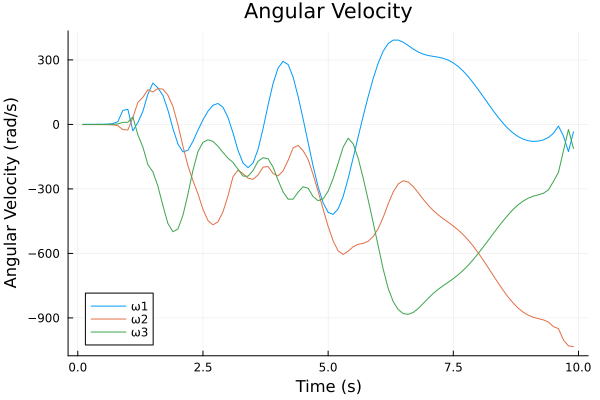

In [149]:
w_hist = [Vector(x.angular_velocity) for x in hist]
w_hist = SP.vec_to_mat(w_hist)
plot(time, w_hist, title="Angular Velocity", xlabel="Time (s)", ylabel="Angular Velocity (rad/s)", labels=["ω1" "ω2" "ω3" "||ω||"])

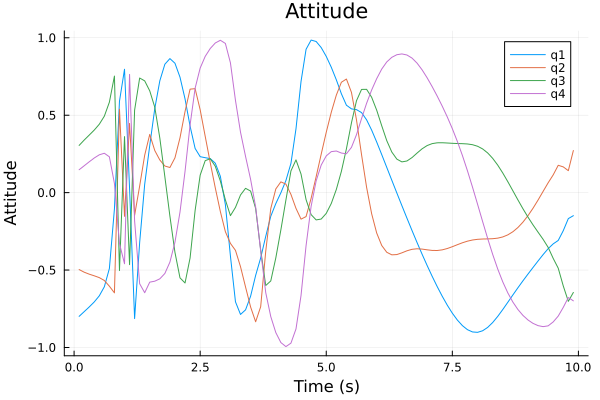

In [150]:
q_hist = [Vector(x.attitude) for x in hist]
q_hist = SP.vec_to_mat(q_hist)
plot(time, q_hist, title="Attitude", xlabel="Time (s)", ylabel="Attitude", labels=["q1" "q2" "q3" "q4"])

In [132]:
attitude =[Vector(Xsim[i].attitude) for i in 1:N]

100-element Vector{Vector{Float64}}:
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.2555180207073509, -0.7641026648204687, -0.5073984726007597]
 [0.3056214140247249, -0.255

In [129]:
using Plots

In [130]:
data = reduce(hcat, attitude)'

100×4 adjoint(::Matrix{Float64}) with eltype Float64:
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 ⋮                               
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621  -0.255518  -0.764103  -0.507398
 0.305621

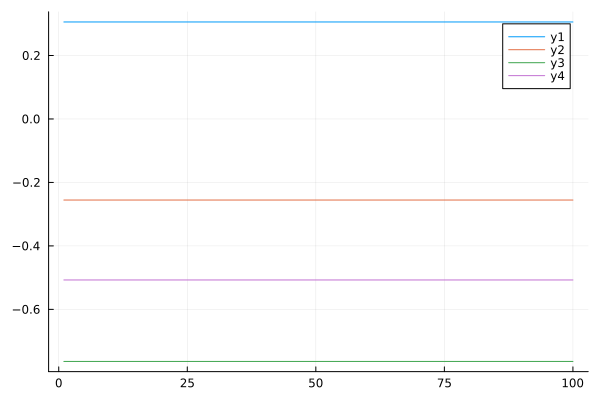

In [131]:
plot(data)